# An Introduction to the Wasserstein Auto-encoder
**A tutorial inspired by the paper "[Wasserstein Auto-Encoders](https://arxiv.org/pdf/1711.01558.pdf)" by Tolstikhin, Bousquet, Gelly & Schölkopf (2017)**

-------

## Contributors
Joel Dapello (FAS)<br>
Michael Sedelmeyer (DCE)<br>
Wenjun Yan (DCE)

**TF Advisor:** Patrick Ohiomoba

-------

**Please Note**: Prior to running the code presented in the [Appendices](#appendix) of this tutorial, please ensure that the required target sub-directories and files are located in your active directory. One way to ensure this is to run only the version of this notebook contained within the .zip archive submitted via canvas. That zipped archive will also mirror the structure presented on our group's associated Wasserstein tutorial [GitHub repository](https://github.com/sedelmeyer/wasserstein-auto-encoder).

-------

<a id="top"></a>
## Contents

- [Introduction and motivation for the Wasserstein auto-encoder](#intro)
- [Conceptual frameworks and algorithms](#concepts)
    - [The basic non-stochastic auto-encoder](#concept1)
    - [The variational auto-encoder](#concept2)
    - [The Wasserstein auto-encoder](#concept3)
    
    
- [Comparing results by model type](#results)
    - [MNIST results](#mnist)
    - [FashionMNIST results](#fmnist)
    
    
- [Conclusions and further analysis](#conclusion)
- [References](#sources)

- [Appendices: PyTorch Implementation](#appendix)
    - [Appendix A: Auto-encoder](#ae)
    - [Appendix B: Variational auto-encoder](#vae)
    - [Appendix C: Wasserstein auto-encoder](#wae)
    - [Appendix D: Test reconstruction loss](#loss)
    - [Appendix E: Plotting functions](#plots)
    
**A list of exhibits contained in this tutorial**

- [Algorithm 1: Basic non-stochastic auto-encoder pseudocode](#algo1)
- [Algorithm 2: Variational auto-encoder pseudocode](#algo2)
- [Algorithm 3: Wasserstein auto-encoder with GAN-based penalty (WAE-GAN) pseudocode](#algo3)


- [Figure 1: Conceptual comparison of auto-encoder reconstruction methods](#fig1)
- [Figure 2: A representation of the convolutional auto-encoder model](#fig2)
- [Figure 3: A representation of the convolutional variational auto-encoder model](#fig3)
- [Figure 4: A representation of the convolutional Wasserstein auto-encoder model](#fig4)
- [Figure 5: Comparison of test reconstruction loss results with MNIST and FashionMNIST](#fig5)
- [Figure 6: Comparison of MNIST reconstructions by auto-encoder type](#fig6)
- [Figure 7: Comparison of MNIST random latent space samples reconstructed](#fig7)
- [Figure 8: Comparison of MNIST linear interpolations by auto-encoder type](#fig8)
- [Figure 9: Comparison of FashionMNIST reconstructions by auto-encoder type](#fig9)
- [Figure 10: Comparison of FashionMNIST random latent space samples reconstructed](#fig10)
- [Figure 11: Comparison of MNIST linear interpolations by auto-encoder type](#fig11)
- [Figure 12: Detailed plot of FashionMNIST linear interpolations by auto-encoder type](#fig12)

<a id="intro"></a>
## Introduction and motivation for the Wasserstein auto-encoder
[return to top](#top)

#### Generative models and the principles of a basic auto-encoder
Designing generative models capabale of capturing the structure of very high dimensional data is a standing problem in the field of statistical modeling. One class of models that has proved effective for this task is the auto-encoder (AE). AEs are neural network based models that assume the high dimensional data being modeled can be reduced to a lower dimensional manifold, defined on a space of latent variables. To do this, the AE defines an encoder network $Q$ which maps a high dimensional input to a low dimensional latent space $Z$, and a generator network $G$ which maps $Z$ back to the high dimensional input space. The whole system is trained end to end with stochastic gradient descent, where, in the case of the basic AE, the cost function is designed to minimize the distance between the training data $X$ and it's reconstruction, $\hat{X} = G(Q(X))$. While the basic AE is quite effective at learning a low dimensional representation of the training data, it is prone to overfitting, and typically fails as a generative model. This is because with no constraint on the shape of the learned representation in latent space, it is unclear how to effectively sample from $Z$. For instance, passing randomly drawn latent codes which are far from the those that $G$ has learned to decode often lead to the generation of nonsense.

#### Constraining the latent space with the variational auto-encoder
The well-known variational auto-encoder (VAE) (Kingma & Welling, 2014) was introduced as a solution to this problem. The VAE builds on the AE framework with a modified cost function designed to maximize the evidence lower bound between the model and target distribution. This effectively introduces a regularization penalty which pushes $Q_Z=Q(Z|X=x)$ to match a specified prior distribution, $P_Z$. Thus, the VAE functions as a much more powerful generative model than the standard AE, because samples drawn from the $P_Z$ are in a range that the $G$ has learned to generate from. Unfortunately, while the VAE performs admirably on simple datasets such as MNIST, (LeCun et al., 1998) with more complex datasets the VAE tends to recreate blurred samples, as the constraint on the latent space pushes all decoded samples towards an idealized mean sample.

#### Improving disentanglement in the latent space with the Wasserstein auto-encoder
In 2018 with the International Conference on Learning Representations paper "Wasserstein Auto-Encoders", the authors Tolstikhin et al. propose the Wasserstein auto-encoder (WAE) as a new algorithm for building a latent-variable-based generative model. This new addition to the family of regularized auto-encoders aims to minimize the optimal transport cost, $\mathcal{D}_Z(Q_Z,P_Z)$ (Villani, 2003) formulated as the Wasserstein distance between the model distribution $Q_Z$ and the target $P_Z$ distribution. The optimal transport cost can be thought of intuitively as the cost to transform one distribution into another, and leads to a different regularization penalty than that of the VAE. The WAE regularizer encourages the full encoded training distribution to form a continuous mixture matching the prior $P_Z$ rather than individual samples as happens in the case of the VAE (see [Figure 1](#fig1)). For this reason, the WAE shares many of the properties of VAEs, while generating better quality samples due to a better disentangling of the latent space from the optimal transport penalty.

#### About this tutorial
In this tutorial, we implement the generative adversarial network (GAN) formulation of WAE (WAEgan). The WAEgan uses the Kantorovich-Rubinstein duality (Arjovsky et al., 2017), expressed as an adversarial objective on the latent space. Specifically, the WAEgan implements a discriminator network $D$ in the latent space $Z$ trying to differentiate between samples drawn from $P_Z$ and samples drawn from $Q_Z$, essentially setting $\mathcal{D}_Z(Q_Z,P_Z)=D(Q_Z,P_Z)$, and forcing $Q$ to learn to generate latent codes that fool the discriminator $D$. In addition to implementing the WAEgan, we implement a VAE and basic AE as well. We choose this approach because, to better understand the WAE and its benefits, it is important to consider WAE within the context of these two preceeding and well-established algorithms. This approach provides a more intuitive understanding of the results by demonstrating side-by-side comparisons of each algorithm applied to the popular MNIST and FashionMNIST (Xiao et al., 2017) datasets with convolutional nueral network (CNN) implementations in PyTorch. 

<a id="fig1"></a>
**Figure 1:** Conceptual comparison of AE reconstruction methods (after Tolstikhin et al., 2018). All three algorithms map inputs $x \in X$ to a latent code $z \in Z$ and then attempt to reconstruct $\hat{x}=G(z)$. The AE places no regularization penalty on $Z$, while the VAE and WAE use Kullback–Leibler divergence ($D_{KL}$) and optimal transport cost respectively to penalize divergence of $Q_Z$ from the shape of the prior, $P_Z$. While the VAE formulation forces Q(Z|X=x) to match $P_Z$, the optimal transport cost enforces the continuous mixture $Q_z:=\int Q(Z|X) dP_x$ to match $P_Z$.

<img src="./images/figure 1 - reconstruction.png" class="center" width="800"/>

<a id="concepts"></a>
## Conceptual frameworks and algorithms
[return to top](#top)

To better understand the WAE, it is helpful to consider the development of auto-encoder models beginning with a basic non-stochastic AE, followed by the VAE, and then on to WAE. Below, we include algorithms and schematics of all three autoencoders, with the hyperparameters for latent dimension and convolutional filter size like those used to generate our results. In this tutorial, for consistency among our models, we have translated the notation for the auto-encoder and variational auto-encoder to match the notational conventions used in "Wasserstein Auto-encoders" (Tolstikin et al., 2017).

<a id="concepts1"></a>
### The basic non-stochastic auto-encoder
[return to top](#top)

We implemented a convolutional auto-encoder similar to the popular DCGAN model (Radford et al., 2015). Convolutions can be thought of as encoding hard priors on the weight space of the model, enforcing the assumption that signal statistics coming in to the convolutional layer are spatially local. The AE uses a deterministic encoder network $Q_{\phi}$ to map an input $x$ to the latent space $Z$, while a deterministic decoder network $G_{\theta}$ maps latent codes $z$ to the input space $X$. The whole network is trained by descending a specified cost function, in our case mean squared error, defined on the pixel space such that the reconstruction $\hat{x}=G_{\theta}((Q_{\phi}{x}))$ matches the input image $x$.

<a id="fig2"></a>
**Figure 2:** Representation of the convolutional non-stochastic auto-encoder (AE) model

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo1"></a>
**Algorithm 1:** Pseudocode for the basic non-stochastic auto-encoder

> Initialize the parameters fo the encoder $Q_{\phi}$, decoder $G_{\theta}$.

> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> Sample $\tilde{z}_i$ from $Q_{\phi}(x_i)$ for $i=1, \dotsc , n$
 
>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$C(x_i, G_{\theta}(\tilde{z}_i))$$

> **end while**

<a id="concepts2"></a>
### The variational auto-encoder
[return to top](#top)

The VAE builds on the AE by specifying a very specific cost function: the evidence lower bound (ELBO). In the context of the VAE, maximizing the ELBO equates to minimizing the negative log likelyhood in pixel space, with an additional Kullback-Leibler divergence ($D_{KL}$) term which penalizes the divergence of the latent code from the prior, $P_Z$. To implement the VAE, we use the reparameterization trick, wherein the network $Q_{\phi}$ is adjusted to estimate $\mu$ and $\sigma$ which are then transformed as $\tilde{z}=\mu+\sigma \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$. The reparameterization trick allows us to easily calculate the gradients across the whole network, while still generating a random variable $\tilde{z}$.

<a id="fig3"></a>
**Figure 3:** Representation of the convolutional variational auto-encoder (VAE) model

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/variational%20auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo2"></a>
**Algorithm 2:** Psuedocode for the Variational auto-encoder (from Kingma & Welling, 2014)

**Constraint:** Latent vector fits gaussian distribution.

> Initialize the parameters for the encoder $Q_{\phi}$, decoder $G_{\theta}$.

> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> generate $\mu_i$ and $\sigma_i$ from $Q_{\phi}(x_i)$ for $i=1, \dotsc , n$

>> generate $\tilde{z}_i=\mu_i+\sigma_i \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0,1)$ for $i=1,\dotsc , n$

>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$ \sum_{i=1}^n -\mathbb{E}_{\tilde{z} \sim Q_{\phi}(Z|x_i)}[log G_{\theta}(x_i|\tilde{z}_i)] + D_{KL}(Q_{\phi}(\tilde{z}_i|x_i)||P_Z) $$

> **end while**

<a id="concepts3"></a>
### The Wasserstein auto-encoder
[return to top](#top)

The WAEgan builds on the basic framework of the AE, but adds an adversarial discriminator network $D_{\gamma}$ in the latent space $Z$. $D_{\gamma}$ is trained alongside $Q_{\phi}$ and $G_{\theta}$ to discriminate between samples from the prior $P_Z$ and samples from $Q_{\phi}(X)$. Thus in addition to a cost on image reconstruction (we use binary cross entropy on the pixel space) the WAEgan has an added penalty when the encoder $Q_{\phi}$ encodes examples which fail to fool $D_{\gamma}$, and a hyperparameter $\lambda$ to control the scale of this penalty. As shown by Arginsky et al., (2017), this adversarial penalty leads to the dual formulation of the Wasserstein distance and minimizes the optimal transport cost by encouraging $Q_z:=\int Q(Z|X) dP_x$ to match $P_Z$.

<a id="fig4"></a>
**Figure 4:** Representation of the convolutional Wasserstein auto-encoder (WAEgan) model

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/wasserstein%20auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo3"></a>
**Algorithm 3:** Psuedo code for the Wassertein auto-encoder with GAN-based penalty (WAEgan) (Tolstikhin et al., 2018)

**Require:** Regularization coefficient $\lambda > 0$.
> Initialize the parameters fo the encoder $Q_{\phi}$, decoder $G_{\theta}$, and latent discriminator $D_{\gamma}$.

> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> Sample $\{z_1, \dotsc , z_n\}$ from the prior $P_z$

>> Sample $\tilde{z}_i$ from $Q_{\phi}(Z\vert x_i)$ for $i=1, \dotsc , n$

>> Update $D_{\gamma}$ by ascending:
$$\frac{\lambda}{n}\sum_{i=1}^n log \; D_{\gamma}(z_i) + log (1-D_{\gamma}(\tilde{z}_i))$$

>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$\frac{1}{n}\sum_{i=1}^n c(x_i, G_{\theta}(\tilde{z}_i)) - \lambda \cdot log\;D_{\gamma}(\tilde{z}_i)$$

> **end while**

<a id="results"></a>
## Comparing results by model type
[return to top](#top)

In this section we briefly review the results of each modeling method &mdash; the basic auto-encoder, the variational auto-encoder, and the Wasserstein auto-encoder with GAN-based penalty &mdash; as we have implemented and applied them to both the MNIST and FashionMNIST datasets. While the MNIST dataset was used in the original WAE paper as a means to compare results between the VAE and WAEgan as they were implemented by Tolstikhin et al. (2017), we decided to also apply these models, along with the basic auto-encoder, to the FashionMNIST dataset as well. This additional comparison provides an alternate example on similar dataset with the same input dimensionality, but presumably with and more complex latent manifold.

#### Model parameters used
Our results described below were generated using PyTorch implementations of our models with hyperparameters specified below:

| Parameter   |  Value       |  Description          |
|-------------|:------------:|:----------------------|
| `dim_h`     |  40          | factor controlling the size of hidden layers |
| `n_channel` |  1           | number of channels in the input data (greyscale = 1) |
| `n_z`       |  20          | number of dimensions in latent space |
| `sigma`     |  1.0         | variance in n_z used for WAE random draws for the descriminator |
| `lambda`    |  0.01        | hyperparameter for the weight of the discriminator loss |
| `lr`        |  0.0002      | learning rate for the Adam optimizer |
| `epochs`    |  50          | number of epochs completed by the model |
| `batch_size`| 256          | batch size for stochastic gradient descent |

Please refer to the [Appendices](#appendix) of this tutorial to review the fully coded implementations of each model in PyTorch, and note that our implemented `dim_h` factor controlling the size of our hidden layers matches the dimensions noted in each of our three representational models illustrated in Figures [2](#fig2), [3](#fig3), and [4](#fig4) above.


#### Test reconstruction loss results (MNIST and FashionMNIST)

As was anticipated based upon the stated benefits of the WAEgan as compared to the particular weaknesses of the VAE described in earlier sections of this tutorial, we see improved reconstruction performance for WAEgan on both the MNIST and FashionMNIST datasets (see [Figure 5](#fig5) below). This would indicate that the WAEgan generated clearer image reconstructions which were better matched to the original test images. However, also as was anticipated, the basic AE model outperformed both the VAE and WAEgan when measuring for test reconstruction loss. While this indicates that the AE is best suited for generating basic reconstructions that match the original test images &mdash; at least in the case of this implementation on the low dimension MNIST and FashionMNIST datasets &mdash; we expect the AE to perform more poorly when it comes to generating interpretable images when drawn from other points within its latent space. This is where the regularization penalties imposed by the VAE and WAEgan algorithms to make their latent distributions continous should offer a clear benefit over the AE.


<a id="fig5"></a>
**Figure 5:** Comparison of test reconstruction loss results by model and dataset

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstruction_loss.png?raw=true" class="center" width="500"/>

|               |  AE  | VAE  | WAEgan  |
|---------------|:----:|:----:|:-------:|
| MNIST 	    |0.0048|0.0095|0.0071   |
| FashionMNIST 	|0.0083|0.0137|0.0093   |

Note however, in our implementation the WAEgan has a free parameter '$\lambda$' not considered in the VAE. As a follow up analysis and for a more "fair" comparison between models, we would recommend adding  a $\lambda$ parameter to the KL divergence of the VAE as well.

<a id="mnist"></a>
### MNIST results
[return to top](#top)

In the plots below we provide visualizations showing a series of pixel space representations of the test set from the MNIST dataset compared to decoded representations from each of our auto-encoder implementations, AE, VAE, and WAEgan, each as a row of images in that respective order. These plots provide a means to visually inspect how each auto-encoder performed reconstructing the MNIST test images. These images give us a sense of whether or not any of the auto-encoders were overfit to the training set, as well as a first glance at each auto-encoder's 20-dimensional latent space $Z$ through its decoded "interpretation" of regions not mapped directly to a learned training image.

While all three auto-encoders perform very well on MNIST, for instance, in [Figure 6](#fig6) below we can see that some of the more "abnormal" details for digits in the first row (most notably the jagged shape at the top of the far left zero [0] and the stray mark beside the second one [1]) are captured and rendered in the reconstructions provided by the AE as well as the WAEgan, but notably not by the VAE. While all three auto-encoders appear to do a generally good job of reconstructing our input images, it is this added level of detail and accuracy that we would expect for both the AE and WAEgan as was evidenced by their superior test reconstruction loss scores when compared to the VAE.

<a id="fig6"></a>
**Figure 6:** Comparison of MNIST reconstructions by implemented auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstructions_MNIST.png?raw=true" class="center" width="700"/>

Next, in [Figure 7](#fig7) we draw random samples $Normal(0,1)$ from the latent space of each auto-encoder to better explore that space. In this example, we provide as reference in row 1 the noisy representation that similar sampling provides when drawn from the pixel space of our original MNIST training images. This is then compared, row-by-row, to the decoded representations of random samples from the latent spaces of the AE, VAE, and WAEgan. Here we would expect less "noise" in our VAE and WAE representations leading to representations better resembling actual digits than the AE. We would expect this primarily because of the basic AE's lack of a continous distribution in the latent space, meaning that when we feed it random gaussian sample codes, we are more likely to hit regions of the latent space the AE has seen before. On the otherhand, due to their regularization penalties, feeding random gaussian sample codes to the VAE and WAEgan is more likely to hit regions of the latent space they can generate meaningful images from. While the AE's results in Figure 7 do appear to be less discernible and slightly noisier than those of the VAE and WAE, this is negligible and it is not until the we plot our FashionMNIST results further below ([Figure 10](#fig10)) that we see a more notable difference between each model type when randomly sampling from the latent space.

<a id="fig7"></a>
**Figure 7:** Comparison of MNIST random latent space samples reconstructed by auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/random_MNIST.png?raw=true" class="center" width="700"/>

As a final comparison with MNIST, we look at the linear interpolations between each consecutive digit selected from the training set in [Figure 6](#fig6). Thus, [Figure 8](#fig8) shows nine equally spaced interpolations between each digit. The first row in each block of images shows the transition in pixel space, where we can clearly see the starting digit slowly fades out as the next digit fades into its place. This is contrasted with the linear interpolations in the latent space for each set of digits. For the AE, VAE, and WAE we can see the morphology of these digits, one onto the next, as we traverse the latent space between each digit. Here we can see that each type of auto-encoder has represented this space in a slightly different, but relatively continous manner.

<a id="fig8"></a>
**Figure 8:** Comparison of MNIST linear interpolations by implemented auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/grid_interpolations_MNIST.png?raw=true" class="center" width="700"/>

<a id="fmnist"></a>
### FashionMNIST results
[return to top](#top)

Similar to the MNIST results reviewed above, we now provide visualizations of our results using the FashionMNIST dataset. As mentioned before, the FashionMNIST dataset was chosen for its similarity to the MNIST dataset, while also allowing us to compare AE, VAE, and WAEgan reconstruction results on a set of training images with a more complex latent manifold.

In [Figure 9](#fig9) we can see that all three auto-encoders generally performed well in their reconstructions of our sampled training images. This time however, it is noteable that some of the more unique details of a particular article of clothing (such as the printed image on the far left shirt or the bow along the neckline of the third shirt from the left) are poorly reconstructed by our auto-encoders. Our intuition tells us that those details do not contribute heavily to the image reconstruction loss, and thus are treated with very little importance during each algorithm's dimensionality reduction, leading to their exclusion from the image reconstruction.

<a id="fig9"></a>
**Figure 9:** Comparison of FashionMNIST reconstructions by implemented auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstructions_FMNIST.png?raw=true" class="center" width="700"/>

One of the more notable results for FashionMNIST, particularly when compared to the similar MNIST plot, are the discernible differences among the AE, VAE, and WAEgan randomly sampled latent space reconstructions as are shown in [Figure 10](#fig10) below. While there appeared to be little visual difference in reconstructions for the MNIST examples, FashionMNIST demonstrates far less interpretable AE random latent space reconstructions. VAE and WAE on the other hand present with reconstructed images much more closely resembling the actual types of objects contained within the FashionMNIST dataset. In other words, many of the randomly sampled reconstructions in rows 3 and 4 actually resemble pants, shirts, shoes, and bags, while the basic auto-encoder (row 2) provides largely nonsensical reconstructions. This would indicate that the learned latent space for both the VAE and WAEgan will be far more effective as generative models than the AE.   

<a id="fig10"></a>
**Figure 10:** Comparison of FashionMNIST random latent space samples reconstructed by auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/random_FMNIST.png?raw=true" class="center" width="700"/>

Lastly, we look at linear interpolations with the FashionMNIST dataset. In this case, images of similar objects, such as one shirt versus another shirt, transition smoothly from one image to the other. The transitions are less smooth for objects of vastly varying shapes, such as a shirt versus a shoe for example. Figures [11](#fig11) and [12](#fig12) provide illustrations of this.

<a id="fig11"></a>
**Figure 11:** Comparison of FashionMNIST linear interpolations by implemented auto-encoder type

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/grid_interpolations_FMNIST.png?raw=true" class="center" width="700"/>

<a id="fig12"></a>
**Figure 12:** Comparison of FashionMNIST linear interpolations by implemented auto-encoder type (detailed)

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/interpolations_FMNIST.png?raw=true" class="center" width="700"/>

<a id="conclusion"></a>
## Conclusions and further analysis
[return to top](#top)

In this tutorial, we have implemented the generative adversarial formulation of the Wasserstein Auto-encoder, as well as a basic non-stochastic auto-encoder and a variational auto-encoder, and compared their performance on the MNIST and FashionMNIST datasets. As claimed by Tolstikhin et. al., we observe that on both datasets the WAE out performs the VAE on test image reconstruction, while also outperforming the standard AE as a generative model, making it the best of both worlds. However, as we have noted perviously, our comparison was not entirely fair as the WAE has an additional free parameter $\lambda$, and for a better comparison we would suggest using a formulation of the VAE which included a hyperparameter to scale the $D_{KL}$ loss term in the VAE.

For additional analysis, we think it would be interesting to compare the WAE, VAE, and AE on more complex datasets such as the celeb faces dataset; following the trend we observed with MNIST and FMNIST, we hypothesize that as the dataset becomes more complex, the benefits of the WAE will become more apparent. We would also suggest using a method such as the Fréchet Inception Distance (FID) (Huesel et. al., 2017) which compares the statistics of generated samples to real samples, to quantitatively compare the quality of the novel generated images.

Moving beyond model comparison and evaluation, we think it would be interesting to try applying the WAE to other new types of high dimensional data suspected to lie on a low dimensional manifold. For instance, various forms of biological data such as RNA expression profiles and neural firing rates are very high dimensional but often exhibit complex underlying correlation structures which might be well modeled by the WAE. 

<a id="conclusion"></a>
## References
[return to top](#top)

1. Arjovsky, M., Chintala, S. and Bottou, L. (2017) "Wasserstein GAN" https://arxiv.org/abs/1701.07875
1. Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. In Advances in Neural Information Processing Systems (pp. 6626–6637).
1. Kingma, D. P. & Welling, M. (2013) "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
1. LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. (1998) "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, http://yann.lecun.com/exdb/mnist/
1. PyTorch (2018). Basic VAE Example.. GitHub Repository, https://github.com/pytorch/examples/tree/master/vae, accessed December 2, 2018.
1. Radford, A., Metz, L., Chintala, S., (2015) "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" https://arxiv.org/abs/1511.06434
1. Tolstikhin, I. O., Bousquet, O., Gelly, S. & Schölkopf, B. (2017). "Wasserstein Auto-Encoders" https://arxiv.org/abs/1711.01558
1. Villani, C. (2003) "Topics in Optimal Transportation" AMS Graduate Studies in Mathematics
1. Xiao, H., Rasul, K., Vollgraf, R. (2017) "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms" https://arxiv.org/abs/1708.07747

<a id="appendix"></a>
## Appendices: PyTorch Implementation
[return to top](#top)

The following appendices contain the PyTorch implementations for the basic auto-encoder ([Appendix A](#ae)), variational auto-encoder ([Appendix B](#vae)), and Wasserstein auto-encoder with GAN-based penalty ([Appendix C](#wae)) used in this tutorial, as well as all associated Python code used to calculate test reconstruction loss for each model ([Appendix D](#loss)) and to generate the plots ([Appendix E](#plots)) embedded in our above analysis of each auto-encoder applied to the MNIST and FashionMNIST datasets.

**User instructions:**

Prior to running the below listed code, please ensure that the required target sub-directories and files are located in your active directory. One way to ensure this is to run only the version of this notebook contained within the .zip archive submitted via canvas. That zipped archive will also mirror the structure presented on our group's associated Wasserstein tutorial [GitHub repository](https://github.com/sedelmeyer/wasserstein-auto-encoder). 

Our PyTorch implementation that follows is currently configured to draw from our saved model weights contained in the associated `./save/` sub-directory. While the plotting functions save to and pull from the `./images/` and `./images/interpolations` sub-directories.

To switch between MNIST and FashionMNIST datasets and model weights, simply change the `args` key value `args['dataset']` in the second code cell below to either `'mnist'` or `'fmnist'`.

If your desire is to re-train the model and to save new weights, this can be accomplished by changing the associated key values `args['train']` and `args['save']` to from `False` to `True`.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

In [2]:
args = {}
args['dim_h'] = 40            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 20              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 0.01         # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 50           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD
args['save'] = False          # save weights at each epoch of training if True
args['train'] = False         # train networks if True, else load networks from saved weights
args['dataset'] = 'fmnist'    # specify which dataset to use

In [3]:
## load Dataset
if args['dataset'] == 'mnist':
    trainset = datasets.MNIST(
        root='./MNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.MNIST(
        root='./MNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
elif args['dataset'] == 'fmnist':
    trainset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
    
train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

<a id="ae"></a>
### Appendix A: The basic auto-encoder 
[return to top](#top)

In [4]:
## create encoder model and decoder model
class AE_Encoder(nn.Module):
    def __init__(self, args):
        super(AE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters organized according to the popular DCGAN 
        # (Radford et. al., 2015) framework, excellent for image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class AE_Decoder(nn.Module):
    def __init__(self, args):
        super(AE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [5]:
# instantiate models, and set to train mode
ae_encoder, ae_decoder = AE_Encoder(args), AE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(ae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(ae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            ae_encoder.train()
            ae_decoder.train()

            ae_encoder.zero_grad()
            ae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            train_recon_loss = criterion(x_hat, images)

            train_recon_loss.backward()

            enc_optim.step()
            dec_optim.step()

        # Run validation set
        ae_encoder.eval()
        ae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        if args['save']:
            save_path = './save/AE_{}-epoch_{}.pth'
            torch.save(ae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(ae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {}\n"\
              "\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            train_recon_loss.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/AE_encoder-best_{}.pth'.format(args['dataset']))
    ae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/AE_decoder-best_{}.pth'.format(args['dataset']))
    ae_decoder.load_state_dict(dec_checkpoint)

<a id="vae"></a>
### Appendix B: The variational auto-encoder
[return to top](#top)

In [6]:
## create encoder model and decoder model
class VAE_Encoder(nn.Module):
    def __init__(self, args):
        super(VAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc1 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        self.fc2 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
        
    # designation of z, mu, and logvar similar to PyTorch VAE example
    # implementation on github (PyTorch 2018)
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def forward(self, x):
        h = self.conv(x)
        h = h.squeeze()
        z, mu, logvar = self.bottleneck(h)
        
        return z, mu, logvar

class VAE_Decoder(nn.Module):
    def __init__(self, args):
        super(VAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [7]:
# instantiate models, and set to train mode
vae_encoder, vae_decoder = VAE_Encoder(args), VAE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of pixel by pixel image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(vae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(vae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            vae_encoder.train()
            vae_decoder.train()

            vae_encoder.zero_grad()
            vae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).sum()
            
            # similar to F.1 example, Algorithm 2 outlined in appendix 
            # of Kingma & Welling, 2014 
            KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            ELBO = BCE - KLD
            ELBO.backward()
                        
            enc_optim.step()
            dec_optim.step()

        # Run validation set
        vae_encoder.eval()
        vae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images) # maybe change to BCE?

        if args['save']:
            save_path = './save/VAE_{}-epoch_{}.pth'
            torch.save(vae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(vae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} \tKLD:{}\n"\
              "\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            KLD.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/VAE_encoder-best_{}.pth'.format(args['dataset']))
    vae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/VAE_decoder-best_{}.pth'.format(args['dataset']))
    vae_decoder.load_state_dict(dec_checkpoint)

<a id="wae"></a>
### Appendix C: The Wasserstein auto-encoder with GAN-based penalty
[return to top](#top)

In [8]:
## create encoder model and decoder model
class WAE_Encoder(nn.Module):
    def __init__(self, args):
        super(WAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class WAE_Decoder(nn.Module):
    def __init__(self, args):
        super(WAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [9]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
wae_encoder, wae_decoder, discriminator = WAE_Encoder(args), WAE_Decoder(args), Discriminator(args)

criterion = nn.MSELoss()

if args['train']:
    enc_optim = torch.optim.Adam(wae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(wae_decoder.parameters(), lr = args['lr'])
    dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)
    dis_scheduler = torch.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

    # one and -one allow us to control descending / ascending gradient descent
    one = torch.tensor([1], dtype=torch.float)
    
    for epoch in range(args['epochs']):

        # train for one epoch -- set nets to train mode
        wae_encoder.train()
        wae_decoder.train()
        discriminator.train()

        for images, _ in tqdm(train_loader):
            # zero gradients for each batch
            wae_encoder.zero_grad()
            wae_decoder.zero_grad()
            discriminator.zero_grad()

            # ======== Train Discriminator ======== #

            # freeze auto encoder params
            frozen_params(wae_decoder)
            frozen_params(wae_encoder)

            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = torch.randn(images.size()[0], args['n_z']) * args['sigma']
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = wae_encoder(images)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['lambda']*torch.log(d_z).mean()
            d_z_hat_loss = args['lambda']*torch.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()

            # ======== Train Generator ======== #

            # flip which networks are frozen, which are not
            free_params(wae_decoder)
            free_params(wae_encoder)
            frozen_params(discriminator)

            batch_size = images.size()[0]

            # run images
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)

            # discriminate latents
            z_hat2 = wae_encoder(Variable(images.data))
            d_z_hat = discriminator(z_hat2)

            # calculate reconstruction loss
            # WAE is happy with whatever cost function, let's use BCE
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).mean()
            
            # calculate discriminator loss
            d_loss = args['lambda'] * (torch.log(d_z_hat)).mean()
            
            # we keep the BCE and d_loss on separate graphs to increase efficiency in pytorch
            BCE.backward(one)
            # -one reverse the direction of the gradient, minimizing BCE - d_loss
            d_loss.backward(-one)

            enc_optim.step()
            dec_optim.step()

        # test on test set
        wae_encoder.eval()
        wae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        
        if args['save']:
            save_path = './save/WAEgan_{}-epoch_{}.pth'
            torch.save(wae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(wae_decoder.state_dict(), save_path.format('decoder', epoch))
            torch.save(discriminator.state_dict(), save_path.format('discriminator', epoch))

        # print stats after each epoch
        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} d loss: {}, \n"\
              "\t\t\tTest Reconstruction Loss:{}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            d_loss.data.item(),
            test_recon_loss.data.item()
        ))
        
else:
    enc_checkpoint = torch.load('save/WAEgan_encoder-best_{}.pth'.format(args['dataset']))
    wae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/WAEgan_decoder-best_{}.pth'.format(args['dataset']))
    wae_decoder.load_state_dict(dec_checkpoint)
    
    dec_checkpoint = torch.load('save/WAEgan_discriminator-best_{}.pth'.format(args['dataset']))
    discriminator.load_state_dict(dec_checkpoint)

<a id="loss"></a>
### Appendix D: Calculate test reconstruction loss
[return to top](#top)

In [10]:
def calc_test_loss(criterion=nn.MSELoss(), args=args, plot=True,
                   model_name_list = ["AE", "VAE", "WAE"],
                   encoder_class_list = [AE_Encoder, VAE_Encoder, WAE_Encoder], 
                   decoder_class_list = [AE_Decoder, VAE_Decoder, WAE_Decoder], 
                   encoder_filepath_list = ['save/AE_encoder-best_{}.pth'.format(args['dataset']),
                                            'save/VAE_encoder-best_{}.pth'.format(args['dataset']),
                                            'save/WAEgan_encoder-best_{}.pth'.format(args['dataset'])],
                   decoder_filepath_list = ['save/AE_decoder-best_{}.pth'.format(args['dataset']),
                                            'save/VAE_decoder-best_{}.pth'.format(args['dataset']),
                                            'save/WAEgan_decoder-best_{}.pth'.format(args['dataset'])]):
    
    ## load full test set as batch size calculating loss
    if args['dataset'] == 'mnist':
        dataset_name = 'MNIST'
        testset = datasets.MNIST(
            root='./data/',
            train=False,
            transform=transforms.ToTensor(),
            download=True
        )

        test_loader = DataLoader(
            dataset=testset,
            batch_size=10000,
            shuffle=False
        )

    elif args['dataset'] == 'fmnist':
        dataset_name = 'FashionMNIST'
        testset = datasets.FashionMNIST(
            root='./FMNIST/',
            train=False,
            transform=transforms.ToTensor(),
            download=True
        )

        test_loader = DataLoader(
            dataset=testset,
            batch_size=10000,
            shuffle=False
        )
    
    # Create dict to store test loss by model
    test_loss_dict = dict() 
    
    ## Calculate reconstruction test loss for each model
    for Encoder, Decoder, enc_filepath, dec_filepath, model in zip(encoder_class_list, 
                                                                   decoder_class_list, 
                                                                   encoder_filepath_list, 
                                                                   decoder_filepath_list, 
                                                                   model_name_list):
        
        # call encoder and decoder classes and eval each
        encoder, decoder = Encoder(args), Decoder(args)
        encoder.eval()
        decoder.eval()
        
        # load encoder and decoder weights from checkpoint
        enc_checkpoint = torch.load(enc_filepath)
        encoder.load_state_dict(enc_checkpoint)
        
        dec_checkpoint = torch.load(dec_filepath)
        decoder.load_state_dict(dec_checkpoint)
        
        
        if model == "VAE":
            # calculate and save test reconstruction loss for VAE
            for images, _ in test_loader:
                z_hat, mu, logvar = encoder(images)
                x_hat = decoder(z_hat)
                test_loss_dict[model] = criterion(x_hat, images).data.item()
                print('{0} final reconstruction loss {1} on {2}'.format(model, 
                                                                        test_loss_dict[model], 
                                                                        dataset_name))
        else:
            # calculate and save test reconstruction loss for AE and WAE
            for images, _ in test_loader:
                z_hat = encoder(images)
                x_hat = decoder(z_hat)
                test_loss_dict[model] = criterion(x_hat, images).data.item()
                print('{0} final reconstruction loss {1} on {2}'.format(model, 
                                                                        test_loss_dict[model], 
                                                                        dataset_name))
   
    if plot:
        
        print()
        
        # Plot test reconstruction loss results for visual comparison
        loss_list = []
        for model in model_name_list:
            loss_list.append(test_loss_dict[model])

        ymax = np.max(loss_list) + np.max(loss_list)*.15

        fs=16

        fig = plt.figure(figsize=(10,3.5))

        plt.plot(model_name_list, loss_list, "ks-", markersize=10)
        plt.title("Test reconstruction loss by model type for {0}".format(dataset_name), 
                  fontsize=fs)
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs-4)
        plt.ylabel("reconstruction loss\n(MSE)", fontsize=fs-2)
        plt.ylim(bottom=0, top=ymax)
        plt.margins(x=.2)
        plt.grid(linestyle=":")
        plt.show()
            
    print()
        
    return test_loss_dict


AE final reconstruction loss 0.008279001340270042 on FashionMNIST
VAE final reconstruction loss 0.013635538518428802 on FashionMNIST
WAE final reconstruction loss 0.009220210835337639 on FashionMNIST



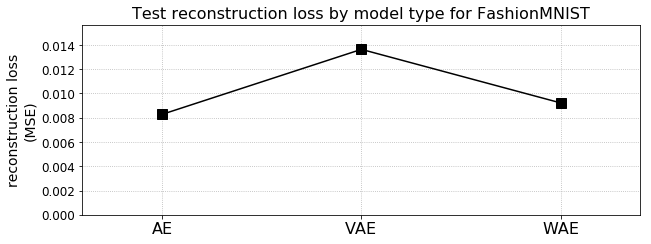


CPU times: user 3min 25s, sys: 7.24 s, total: 3min 33s
Wall time: 39.7 s


In [11]:
%%time

test_loss = calc_test_loss(plot=True)

<a id="plots"></a>
### Appendix E: Plotting functions
[return to top](#top)

In [12]:
def plot_rows(images, save=False, filename="./images/reconstructions.png", 
              width=16, height=6.55, args=args, optimizer_name="Adam", 
              encoders = [ae_encoder, vae_encoder, wae_encoder], 
              decoders = [ae_decoder, vae_decoder, wae_decoder], 
              seed=100, padding=True):
    
    # this function plots a set of 10 original images along with the reconstructions
    # of those images generated by each of our implemented auto-encoders
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    plot_images.append(images[:10].detach().numpy())

    # encode and decode images and save decoded results for plotting
    for i, _ in enumerate(encoders):
        if i == 1:
            # VAE images require special treatment because of additional mu and logvar
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps[0])[:10].detach().numpy())
        else:
            # AE and WAE
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps)[:10].detach().numpy())

    # plot results to 4 separate rows
    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    plt.suptitle("Original images (row 1) compared to reconstructions "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4) implementations", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

In [13]:
def interpolate(z1, z2, steps=10):
    
    # this function calculates latent space interpolations between two images z1 and z2
    
    z_int = torch.zeros([steps, z1.shape[0]])
    
    for i in range(z1.shape[0]):
        start = z1[i].data.item()
        end = z2[i].data.item()
        z_int[:,i] = torch.linspace(start,end, steps=steps)
    
    return z_int


def plot_interpolation(images, start_idx=0, end_idx=1, save=False, show=True,
                       filename="./images/interpolations.png", titles=True,
                       width=16, height=6.55, args=args, optimizer_name="Adam", 
                       encoders = [ae_encoder, vae_encoder, wae_encoder], 
                       decoders = [ae_decoder, vae_decoder, wae_decoder], 
                       seed=100, padding=True):  
    
    # this function plots linear interpolations between two images (start_idx and end_idx)
    # in pixel space as well as latent space for each of our implemented auto-encoders 
    
    torch.manual_seed(seed)

    interp_steps = 9

    plot_images = []
    
    # calculate pixel space interpolation step size based on start and end images
    start_pix = images[start_idx,0].numpy().copy()
    end_pix = images[end_idx,0].numpy().copy()
    diff = end_pix - start_pix
    lin_step_size = diff/interp_steps
    
    # encode and decode image interpolations and save decoded results for plotting
    for i, _ in enumerate(encoders):
        if i == 1:
            # VAE images require special treatment because of additional mu and logvar
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[0][start_idx],z_reps[0][end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())
        else:
            # AE and WAE
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[start_idx],z_reps[end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())

    # plot results to 4 separate rows
    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for i, img in enumerate(axes[0]):
        # calculate and plot pixel space interpolations
        axes[0][i].imshow(start_pix, cmap='gray')
        axes[0][i].axis("off")
        axes[0][i].set_aspect('equal')
        start_pix += lin_step_size
    for row, ax in enumerate(axes[1:]):
        # plot AE, VAE, and WAE interpolations
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    if titles:
        plt.suptitle("Linear interpolation in pixel space (row 1) compared to latent spaces "\
                     "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

        # add footnote with relevant model parameters
        figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                    "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                    "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                         args["dim_h"], 
                                                                                         args["epochs"],
                                                                                         args["batch_size"], 
                                                                                         optimizer_name, 
                                                                                         args["lr"], 
                                                                                         args["sigma"], 
                                                                                         args["lambda"])

        plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

In [14]:
def plot_grid_interpolation(images, save=False, temp_path="./images/interpolations/", 
                            filename="./images/grid_interpolations.png", 
                            width=16, height=7, args=args, optimizer_name="Adam", 
                            seed=100, padding=True):
    
    # this function generates a grid of 9 sets of interpolations
    
    imgs_list = []
    
    # plot and save 9 separate linear interpolations between each of our 10 sampled images
    for i in range(9):
        img_filename = "{0}interpolations_{1}.png".format(temp_path, i)
        plot_interpolation(images, start_idx=i, end_idx=i+1, show=False,
                           titles=False, save=True, filename=img_filename, 
                           seed=seed, padding=False)
        imgs_list.append(img_filename)
    
    # open 9 saved images and combine into a single gridded array for plotting 
    imgs = [ PIL.Image.open(i) for i in imgs_list ]

    imgs_row_0 = np.hstack((np.asarray(i) for i in imgs[:3]))
    imgs_row_1 = np.hstack((np.asarray(i) for i in imgs[3:6]))
    imgs_row_2 = np.hstack((np.asarray(i) for i in imgs[6:]))
    imgs_combined = np.vstack((imgs_row_0, imgs_row_1, imgs_row_2))
    
    # plot combined grid of 9 linear interpolation sets
    fig = plt.subplots(figsize=(width, height))

    plt.imshow(imgs_combined)
    plt.axis("off")

    plt.suptitle("    Linear interpolation in pixel space (row 1 each example) and latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)    

    plt.show()

In [15]:
def plot_random(images, save=False, 
                filename="./images/random.png", 
                width=16, height=6.55, args=args, optimizer_name="Adam", 
                encoders = [ae_encoder, vae_encoder, wae_encoder], 
                decoders = [ae_decoder, vae_decoder, wae_decoder], 
                seed=100, padding=True):
    
    # this function plots random samples N(0,1) from the latent space of 
    # each implemented auto-encoder as well as from pixel space
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    # generate random draw from pixel space
    plot_images.append(torch.randn_like(images).detach().numpy())
    
    # encode and decode random draws from latent space and save decoded results for plotting
    for i, _ in enumerate(encoders):
        if i == 1:
            # VAE images require special treatment because of additional mu and logvar
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps[0])
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())
        else:
            # AE and WAE
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps)
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())

    # plot results to 4 separate rows
    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')


    plt.suptitle("  Random samples $N(0,1)$ of pixel space (row 1) compared to latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()

In [16]:
# load some train images to plot
for images, labels in train_loader:
        break

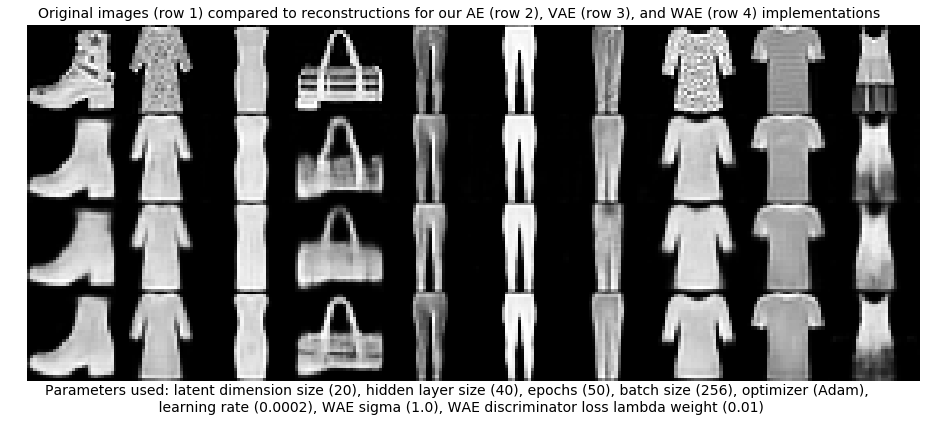

In [17]:
plot_rows(images, save=False, padding=False)

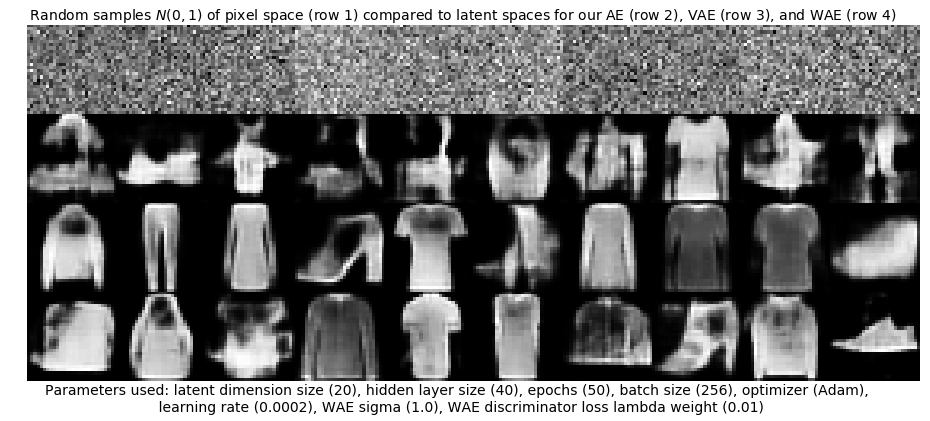

In [18]:
plot_random(images, save=False, padding=False, seed=0)

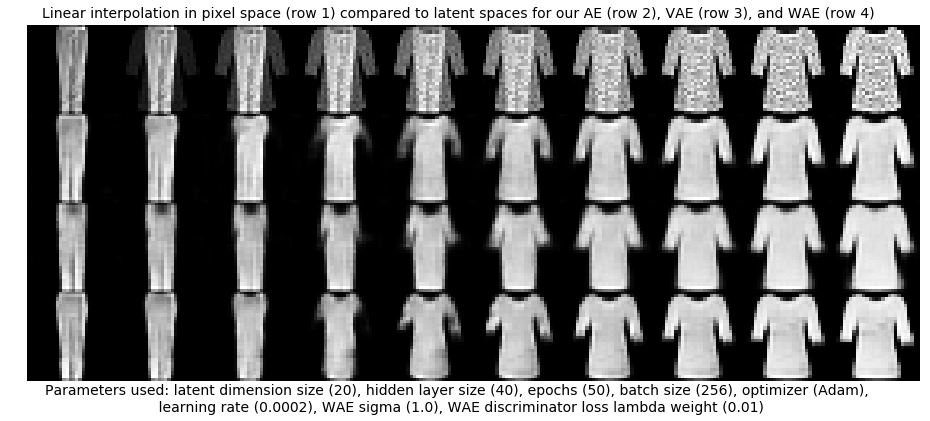

In [19]:
plot_interpolation(images, start_idx=6, end_idx=7, save=False, 
                   show=True, padding=False, titles=True)

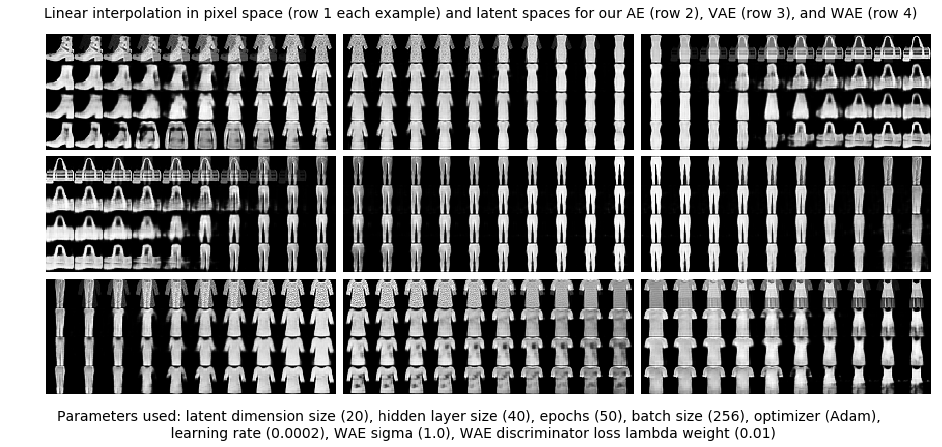

CPU times: user 29.8 s, sys: 454 ms, total: 30.2 s
Wall time: 10.1 s


In [20]:
%%time 

plot_grid_interpolation(images, save=False, padding=False,
                        temp_path="./images/interpolations/")